# パーティクルフィルタによる自己位置推定

In [5]:
import sys
sys.path.append('../src')
import importlib

import worlds
import maps
import numpy as np
import robots
import sensors
import agents
import landmarks
import estimators

def reload():
    importlib.reload(worlds)
    importlib.reload(maps)
    importlib.reload(robots)
    importlib.reload(sensors)
    importlib.reload(agents)
    importlib.reload(estimators)
    importlib.reload(landmarks)


reload()

<IPython.core.display.Javascript object>


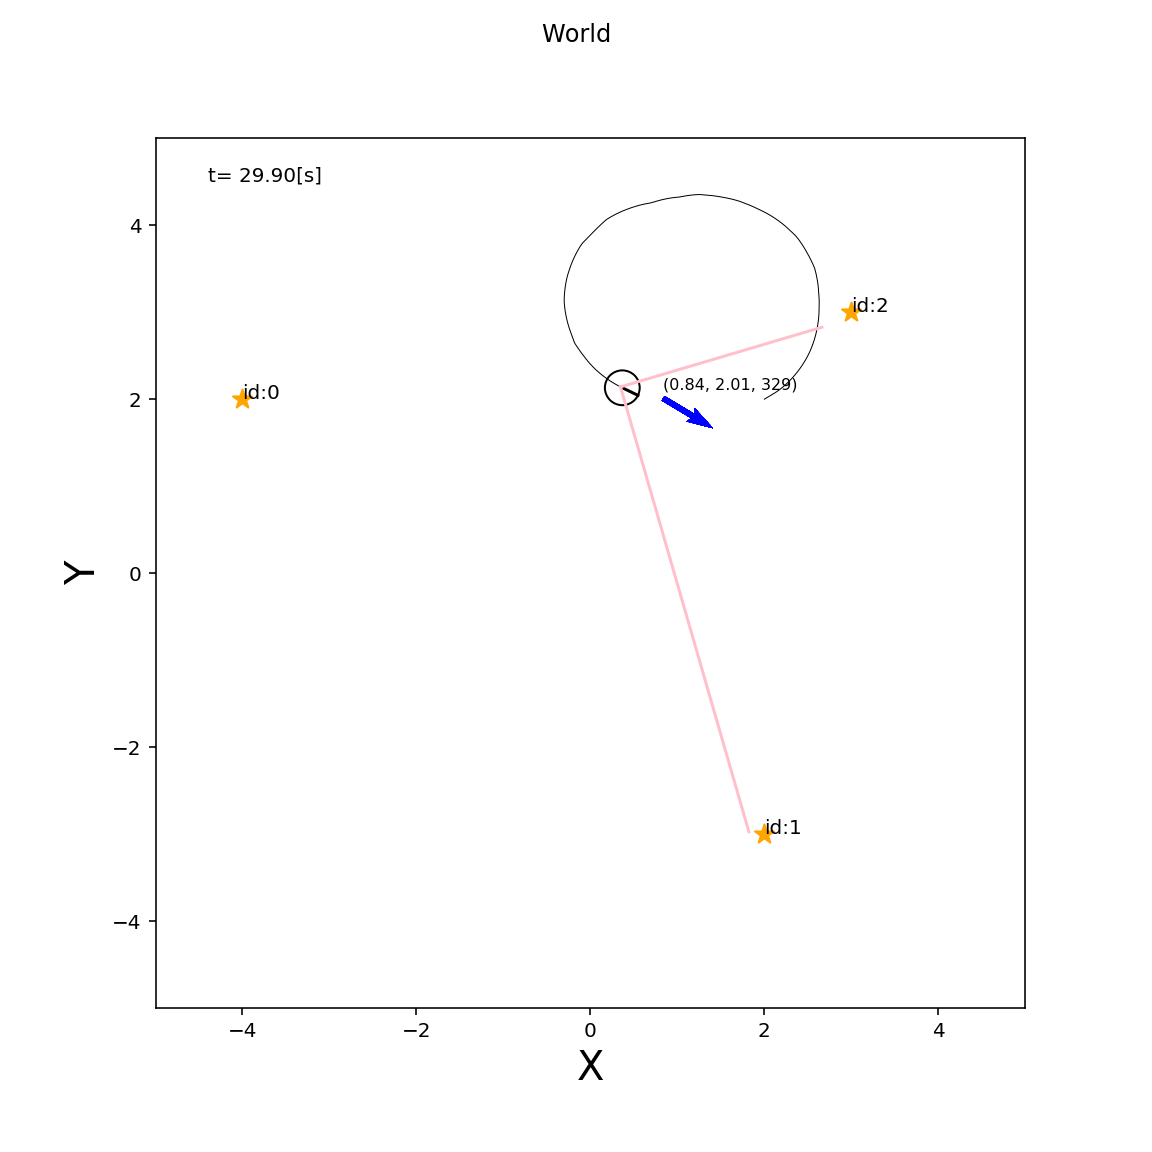

In [6]:
# 手始めにパーティクルを表示
reload()
world = worlds.World(30., 0.1, debuggable=False)
m = maps.Map()
for ln in [(-4., 2.), (2., -3), (3., 3.)]:
    m.append_landmark(landmarks.Point2DLandmark(*ln))
world.append(m)
    
initial_pose = np.array([2., 2., np.pi / 6.]).T
estimator = estimators.Mcl(
    m, initial_pose, 100,
    motion_noise_stds={'nn':0.00001, 'no': 0.00001, 'on': 0.00001, 'oo': 0.00001})
circling = agents.EstimationAgent(
    0.1, 0.2, 10./180.*np.pi, estimator=estimator)
r = robots.Robot(initial_pose, sensor=sensors.Camera(m), agent=circling)
world.append(r)
world.draw()

パーティクルの更新

状態遷移モデルを作ろう

シミュレータでロボットの挙動の統計をとって，作っていく

ノイズが正規分布に従うと仮定してみる

指数分布に従うノイズを入れたりしているが，まずはこれで

このときの雑音パラメータを

- $\sigma_{\nu \nu}$ : 直進1mで生じる道のりのばらつきのstddev
- $\sigma_{\nu \omega}$ : 回転1radで生じる道のりのばらつきのstddev
- $\sigma_{\omega \nu}$ : 直進1mで生じる回転のばらつきのstddev
- $\sigma_{\omega \omega}$ : 回転1radで生じる回転のばらつきのstddev

$\sigma_{a b}$は，$b$が$a$にあたえるばらつきのstddevを表す

$b$があたえる雑音$\delta_{ab}$は移動量・回転量に比例するので

$$
\delta^{2}_{ab} : \left(\delta^{\prime}_{ab} \Delta t \right)^{2} = 1 : |b| \Delta t \\
\\
\delta^{\prime}_{ab} = \delta_{ab} \sqrt{|b| / \Delta t}
$$

$a$, $b$に$\nu$, $\omega$を代入すると制御指令に加えるべき雑音がわかる

これを${\bf \it u}^{\prime}$とすると

$$
\left(
    \begin{array}{c}
        \nu^{\prime} \\
        \omega^{\prime}
    \end{array}
\right) = \left(
    \begin{array}{c}
        \nu^{\prime} \\
        \omega^{\prime}
    \end{array}
\right) + \left(
    \begin{array}{c}
        \delta_{\nu \nu} \sqrt{|\nu| / \Delta t} + \delta_{\omega \nu} \sqrt{|\omega|  / \Delta t} \\
        \delta_{\omega \nu} \sqrt{|\nu| / \Delta t} + \delta_{\omega \omega} \sqrt{|\omega|  / \Delta t}
\end{array}
\right)
$$

シミュレータでロボットを走らせて，これらの値を計測する

In [8]:
# 実装確認コード
reload()

init_pose = np.array([0., 0., 0.]).T
estimator = estimators.Mcl(
    m, init_pose, 100, 
    motion_noise_stds={'nn':0.01, 'no': 0.02, 'on': 0.03, 'oo': 0.04})
a = agents.EstimationAgent(0.1, 0.2, 10./180.*np.pi, estimator)
estimator.motion_update(0.2, 10./180.*np.pi, 0.1)
for p in estimator.particles:
    print(p.pose)

[0.020554   0.00022392 0.02178741]
[0.02397294 0.00015512 0.0129414 ]
[0.01869672 0.00013788 0.01474854]
[0.01754862 0.00024169 0.02754341]
[0.02949873 0.00033601 0.02278059]
[0.02458361 0.00017046 0.01386758]
[0.01827993 0.00015832 0.01732076]
[0.01539366 0.0002373  0.03082817]
[2.11488752e-02 7.28495552e-05 6.88918596e-03]
[0.02419592 0.00025234 0.02085766]
[0.01642275 0.00023969 0.0291885 ]
[0.01618866 0.00013478 0.01665044]
[0.02371417 0.00011781 0.00993541]
[0.0203166  0.00014834 0.01460291]
[0.01781793 0.00015652 0.01756868]
[0.0217315  0.00021264 0.01956872]
[1.85483108e-02 7.25713683e-05 7.82507893e-03]
[1.99751824e-02 8.90261840e-05 8.91362017e-03]
[0.01840796 0.00012632 0.0137246 ]
[2.38077843e-02 6.13863908e-05 5.15682215e-03]
[0.02168265 0.00012935 0.01193149]
[0.02583798 0.00025459 0.01970578]
[0.01636563 0.00019906 0.02432482]
[2.14379530e-02 9.32324790e-05 8.69783522e-03]
[0.0206263  0.00014925 0.01447149]
[0.02114367 0.0001608  0.01520957]
[0.01869066 0.00010129 0.01083

<IPython.core.display.Javascript object>


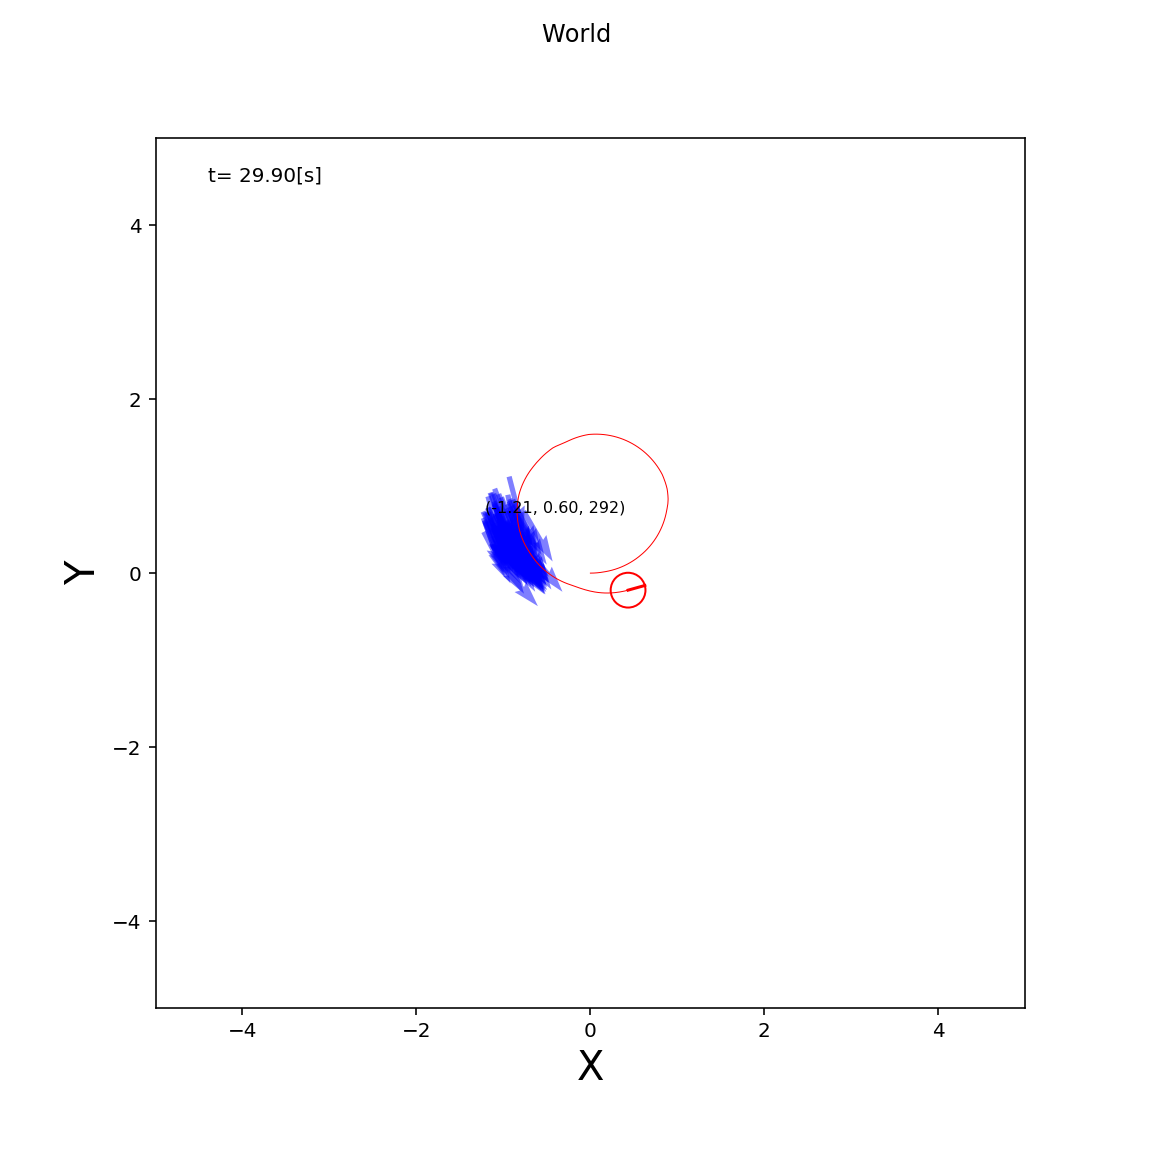

In [9]:
# パーティクルのノイズパラメータを適当に与えてばらつかせてみる
reload()
def trial(motion_noise_stds):
    time_interval = 0.1
    world = worlds.World(30., time_interval)
    map_ = maps.Map()
    
    initial_pose = np.array([0., 0., 0.]).T
    estimator = estimators.Mcl(map_, initial_pose, 100, motion_noise_stds=motion_noise_stds)
    circling = agents.EstimationAgent(
        0.1, 0.2, 10./180.*np.pi, estimator=estimator)
    r = robots.Robot(initial_pose, sensor=None, agent=circling, color='red')
    world.append(r)
    
    world.draw()
    
trial({'nn':0.01, 'no': 0.02, 'on': 0.03, 'oo': 0.04})

In [ ]:
# motion_model_parameterノートブックで求めたパラメータを与えたときのパーティクルの分布
# なんかいい感じに求まらなかったので，原典のパラメータを与えることにした

reload()
trial({'nn':0.19, 'no': 0.0001, 'on': 0.13, 'oo': 0.2})

このときのパーティクルフィルタの分布

$$
P({\bf \it x}^{*} \in \it X) = \int_{x \in X} b_{t}(\bf \it x) d {\bf \it x} \approx \frac{1}{N} \sum_{i=0}^{N-1}\delta({\bf \it x}_{i}^{(i)} \in X)
$$

$\delta (\cdot)$は中身がTrueなら1, Falseなら0を返す関数

X内にあるパーティクルの割合を計算し，

その値を

ロボットの姿勢が$X$ないにある確率とする

In [14]:
# パーティクルに観測後の結果を反映させていく
reload()

# 検証用の関数
def trial():
    time_interval = 0.1
    world = worlds.World(30., time_interval, debuggable=False)
    
    m = maps.Map()
    for ln in [(-4., 2.), (2., -3.), (3., 3.)]:
        m.append_landmark(landmarks.Point2DLandmark(*ln))
    world.append(m)
    initial_pose = np.array([0., 0., 0.]).T
    estimator = estimators.Mcl(m, initial_pose, 100)
    a = agents.EstimationAgent(
        time_interval, 0.2, 10./180.*np.pi, estimator=estimator)
    r = robots.Robot(initial_pose, sensor=sensors.Camera(m), agent=a, color='red')
    world.append(r)
    
    world.draw()

## パーティクルの自己位置をセンサ値から

数式はむずいので，

- 実装
- 本読む
- コメントとlatexで補強

という形で進める

尤度関数のための観測ばらつきの計測はは別notebook sensor_experiment.ipynbで

コミットID f4cf4f74f08378d91bb4e のline 61 でweightに掛け合わせている値は

$$
\it L_{j} ({\bf \mathit x } \mid {\bf \it z}_{j}) = {\mathit N} ( {\bf \mathit z} = {\bf \mathit z}_{j} \mid {\bf \mathit h}_{j} ({\bf \mathit x} ), {\mathit Q}_{j} ({\bf \mathit x}) )
$$

センサ値を固定して，条件付き独立で正規分布であることを期待する

<IPython.core.display.Javascript object>


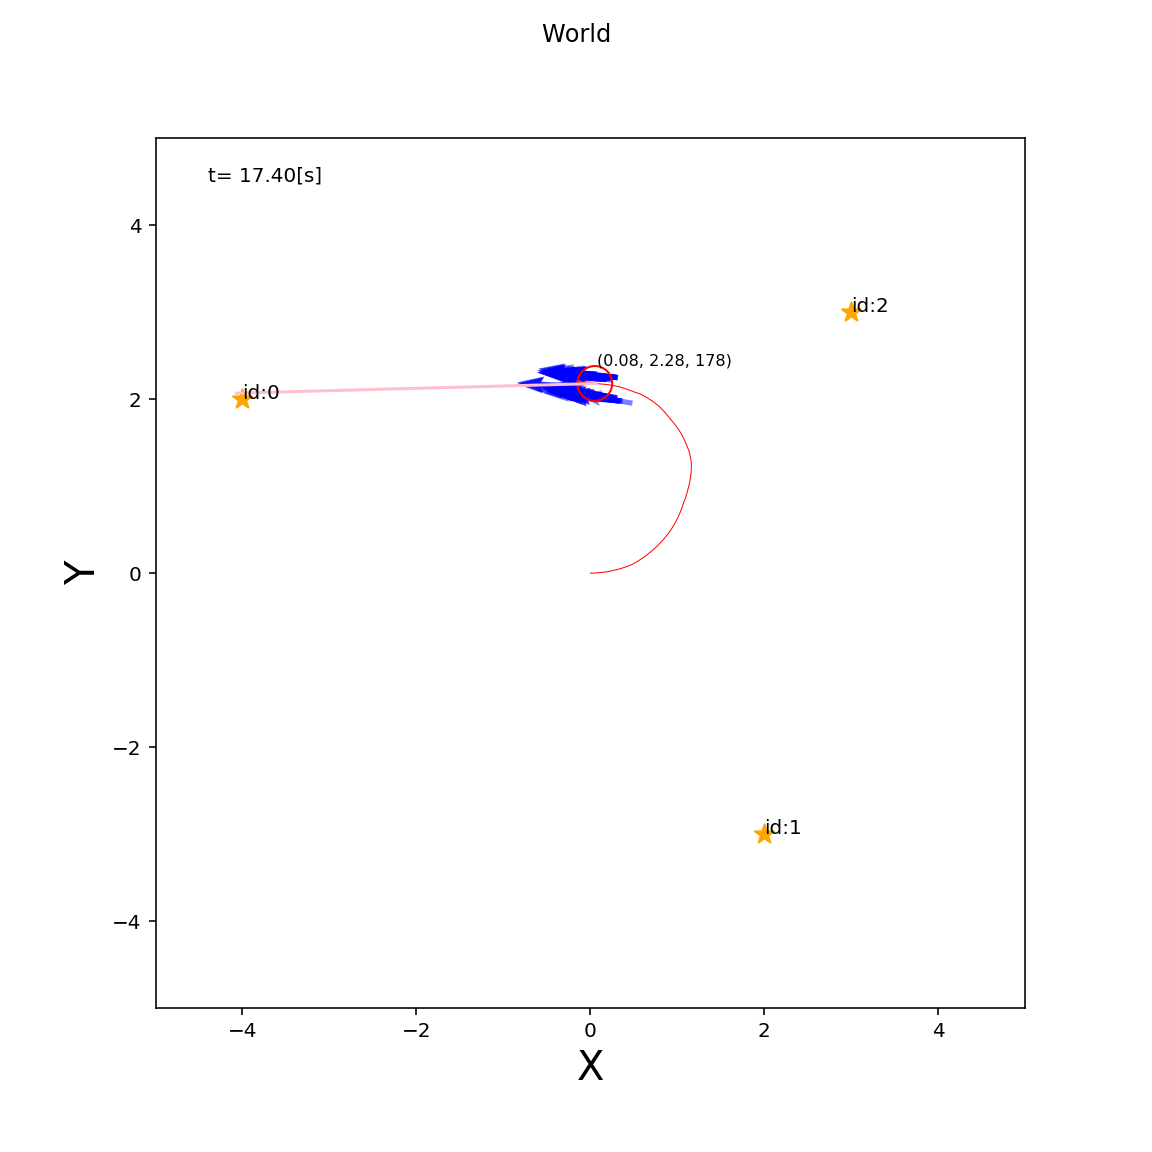

In [16]:
trial()